In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm.auto import trange, tqdm

c:\Users\Cr0l3y\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
(X_treino, y_treino), (X_teste, y_teste) = tf.keras.datasets.fashion_mnist.load_data()
X_treino = (X_treino / 127.5) - 1.0
X_treino = np.expand_dims(X_treino, axis=-1)

In [3]:
IMG_SIZE = 28     
BATCH_SIZE = 128  
timesteps = 16    
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

In [ ]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)
def show_examples(x):
    num_images = x.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(25, num_images)): 
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img.squeeze(), cmap="gray")  
        plt.axis("off")

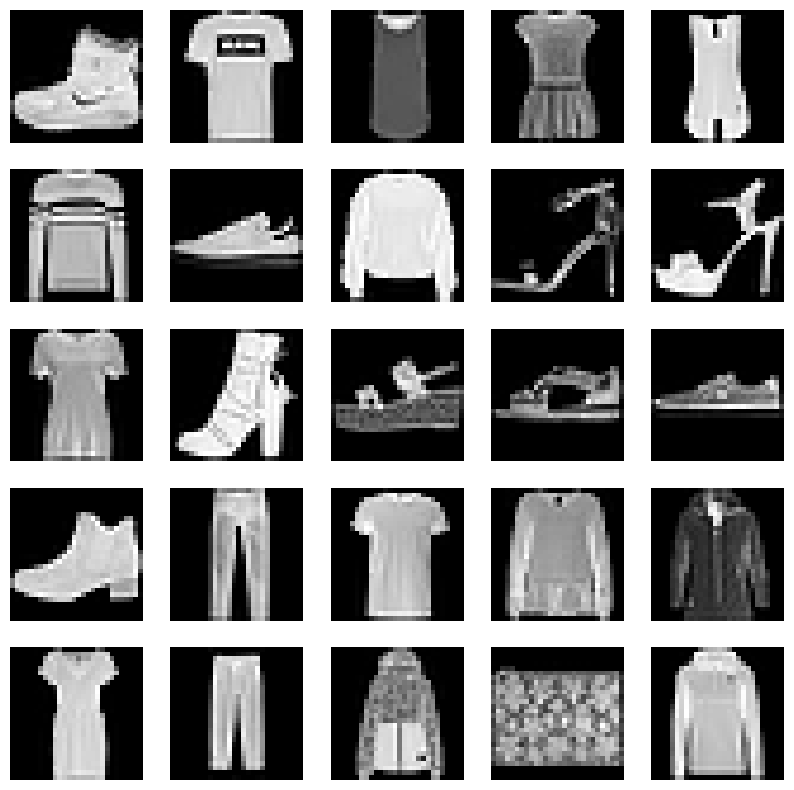

In [5]:
show_examples(X_treino)

In [6]:
def forward_noise(x, t):
    a = time_bar[t]     
    b = time_bar[t + 1] 
    ruido = np.random.normal(size=x.shape) 
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + ruido * a
    img_b = x * (1 - b) + ruido * b
    return img_a, img_b
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

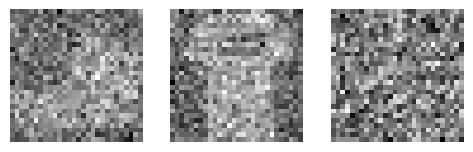

In [7]:
t = generate_ts(3)
a, b = forward_noise(X_treino[:3], t)
show_examples(a)

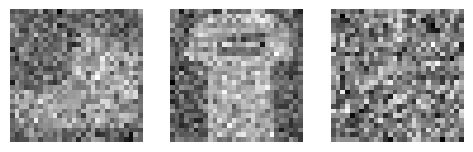

In [8]:
show_examples(b)

In [9]:
def block(x):
    x = layers.Conv2D(128, kernel_size=3, padding="same")(x)
    x= layers.LayerNormalization()(x)
    x= layers.Activation("relu")(x)
    return x

In [14]:
def make_model():
    x = x_input = layers.Input(shape=(28,28,1), name="x_input")
    x_ts = x_ts_input =layers.Input(shape=(1,), name="x_ts_input")
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation("relu")(x_ts)

    x= x28 = block(x)
    x= layers.MaxPool2D(2, padding= "same")(x)
    x= x14 = block(x)
    x= layers.MaxPool2D(2, padding= "same")(x)
    x= x7 = block(x)
    x= layers.MaxPool2D(2, padding= "same")(x)
    x= x4 = block(x)
 
    x= layers.Flatten()(x)
    x= layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    x = layers.Concatenate()([x, x4])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.Cropping2D(((0, 1), (0, 1)))(x)  # 8x8 -> 7x7
    x = layers.Concatenate()([x, x7])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7 -> 14x14
    x = layers.Concatenate()([x, x14])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 14x14 -> 28x28
    x = layers.Concatenate()([x, x28])
    x = block(x)

    x = layers.Conv2D(1, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

In [ ]:
model = make_model()
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008))

Treinamento U-NET

In [19]:
def predict(model, timesteps = 50, batch_size = 32):
    x = np.random.normal(size=(batch_size, 28, 28, 1))
    for i in trange(timesteps):
        t = np.full((batch_size, 1), i)
        x = model.predict([x, t], verbose = 0)
    x = (x - x.min()) / (x.max() - x.min())
    show_examples(x)

**Exemplo do predict(model)**


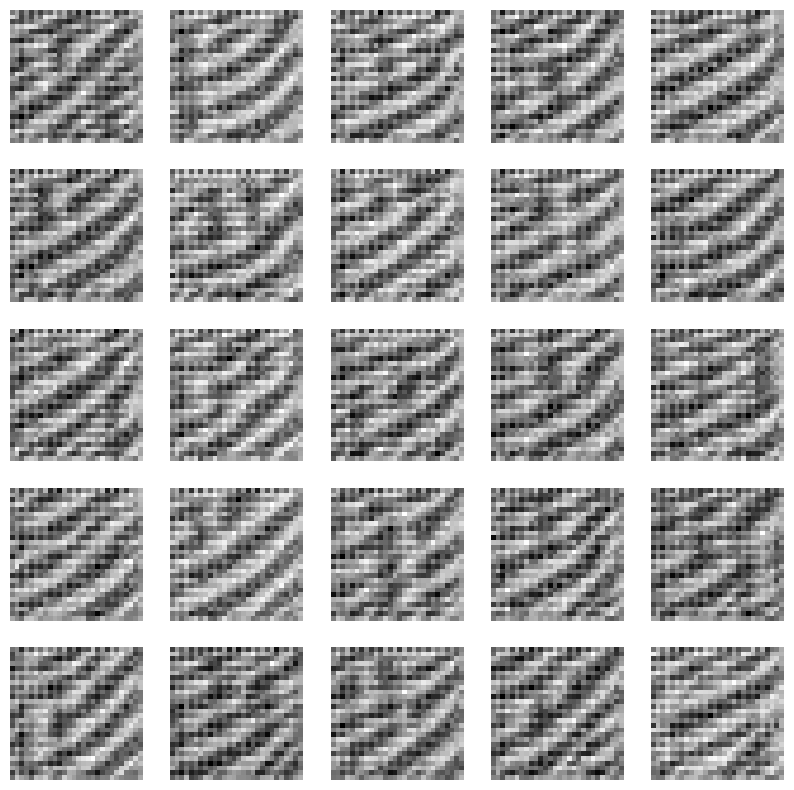

In [23]:
def predict_step(model, timesteps = 50, num_samples = 8):
    xs = []
    x = np.random.normal(size=(num_samples, 28, 28, 1)) 
    for i in trange(timesteps):
        t = np.full((num_samples, 1), i)
        x = model.predict([x, t], verbose = 0)
        if i % 5 == 0:
            xs.append(x[0])
    xs = [(x - x.min()) / (x.max() - x.min()) for x in xs]
    plt.figure(figsize=(20, 3))
    for i, img in enumerate(xs):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(img), cmap='gray')
        plt.title(f'Step {i*5}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

**Exemplo do predict_step(model)**

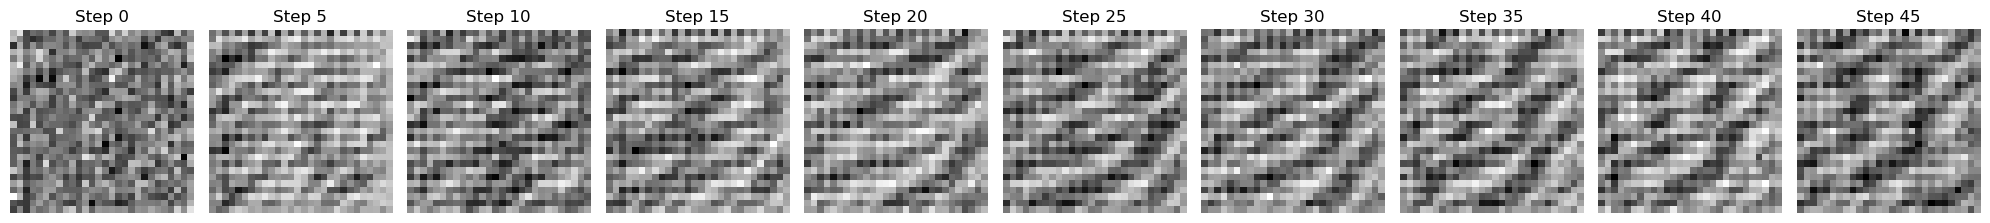


In [25]:
def train_one(x_img):
    x_ts =generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img,x_ts)
    loss = model.train_on_batch([x_a,x_ts],x_b)
    return loss

In [27]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_treino[np.random.randint(len(X_treino), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [28]:
train()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

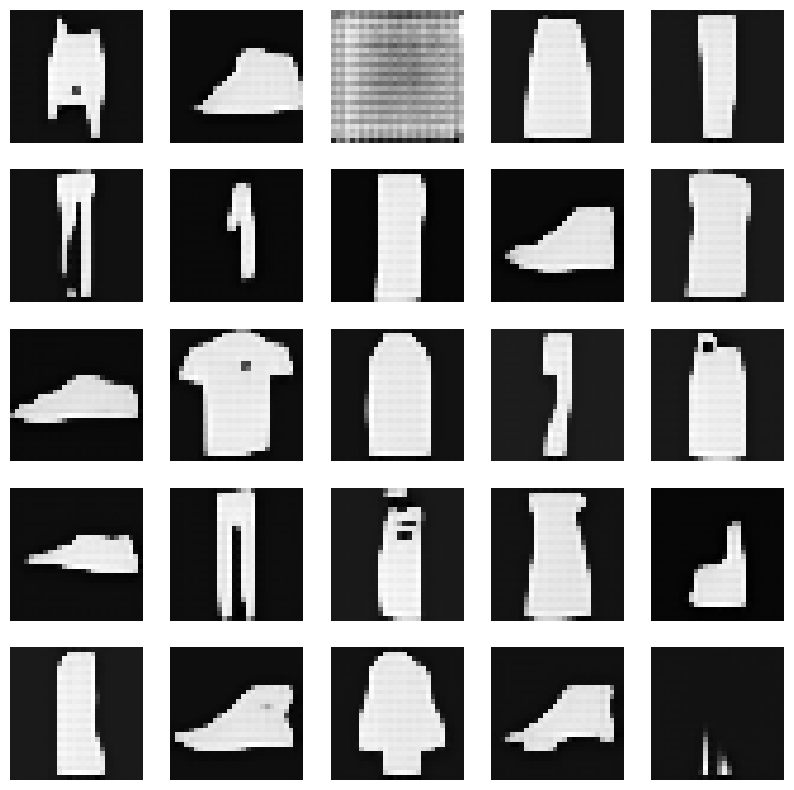

In [29]:
predict(model)

  0%|          | 0/50 [00:00<?, ?it/s]

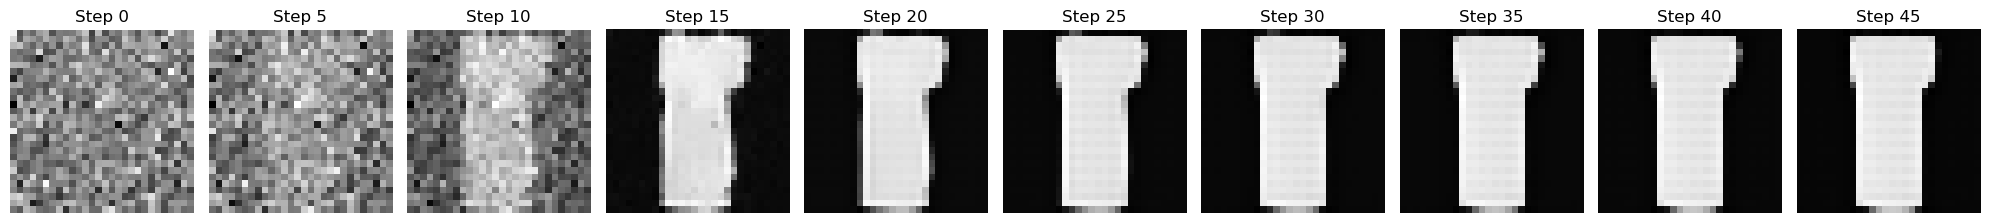

In [30]:
predict_step(model)

In [31]:
model.save("modelo_Dif.keras")